In [123]:
import os
import numpy as np
import pandas as pd
from os import path
import scipy as sp
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from resampy import resample
from librosa.display import specshow

%matplotlib inline

In [124]:
DATA_DIR = "data"

In [125]:
sr = 16000
win_length=int(sr*0.030)
hop_length=int(sr*0.005)


def plot_spec(signal, sr=16000, win_length=None, hop_length=None, return_spec=False):
    if win_length is None:
        win_length = int(sr * 0.030)
        
    if hop_length is None:
        hop_length = int(sr * 0.010)
        
    Sxx = librosa.core.stft(
        signal,
        win_length=win_length,
        hop_length=hop_length,
        n_fft=4096
    )

    spec = librosa.amplitude_to_db(np.abs(Sxx), ref=np.max)
    specshow(
        spec,
        sr=sr,
        x_axis='time',
        y_axis='hz',
        cmap='gray_r'
    )
    plt.colorbar(format='%+2.0f dB')
    
    if return_spec:
        return spec

In [126]:
x, _ = librosa.load(path.join(DATA_DIR, 'clar.wav'), sr=sr)
x = librosa.util.normalize(x)
print(x.shape, x.dtype)

((28800,), dtype('float32'))


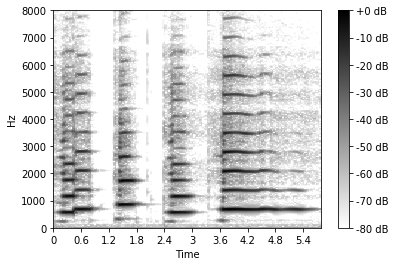

In [127]:
plot_spec(x)
ipd.Audio(x, rate=sr)

In [128]:
noise = 0.05 * np.random.normal(0, 1, len(x))
x_noisy = x + noise
x_noisy = librosa.util.normalize(x_noisy)

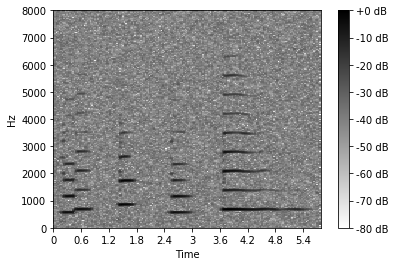

In [7]:
plot_spec(x_noisy)
ipd.Audio(x_noisy, rate=sr)

In [95]:
# from scipy.fftpack import dct, idct
# from scipy import percentile

# def cos_filter(x):
#     cos_frames = np.array([
#         dct(x[i:i+int(sr*0.025)])
#         for i in range(0, len(x), int(sr*0.025))
#     ]).T
#     cos_frames[cos_frames < percentile(cos_frames, 1)] = 0
#     return idct(cos_frames, n=len(x))

# x_cos = cos_filter(x_noisy)
# plot_spec(x_cos)
# plt.figure()
# plot_spec(np.abs(x_cos - x_noisy))
# ipd.Audio(x_cos, rate=sr)

(179, 160)


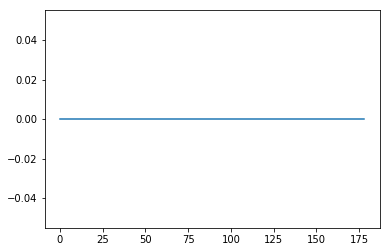

In [141]:
import numpy as np
from aubio import pitch
import pylab as plt
from librosa.util import frame
import seaborn as sns

# sr = 16000
frame_size = int(sr * 0.040)
hop_size = int(sr * 0.010)

x2 = x.reshape((-1, hop_size))[:-1]
print x2.shape

p = pitch('yinfft', buf_size, hop_size, samplerate=sr)
p_est = [p(seg) for seg in x2]

plt.figure()
plt.plot(p_est)

if np.std(p_est) > 0.1:
    plt.figure()
    sns.distplot(p_est)

In [104]:
frame_size

640

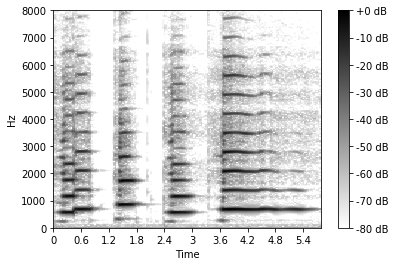

In [129]:
plot_spec(x)

In [98]:
def sinewave(freq, duration, samplerate = samplerate):
    """ generate a sinewave """
    length = hop_size
    while length < duration * samplerate:
        length += hop_size
    return np.sin( 2. * np.pi * np.arange(length) * freq / samplerate ).astype("float32")

y = sinewave(1000, 0.5, sr)
print y.min(), y.max(), y.mean(), y.std()
print x.min(), x.max(), x.mean(), x.std()

-1.0 1.0 0.0 0.707107
-0.854291 1.0 0.00155331 0.179079


In [137]:
def divide_into_frames(y, frame_len, frame_step, fs):
#     frame_len = int(fs*frame_size) # number of samples in a single frame
#     frame_step = int(fs*frame_stride) # number of overlapping samples
    total_frames = int(np.ceil(float(np.abs(len(y)-frame_len))/frame_step))
    print("Frame len %d, frame step %d, total frames %d"%(frame_len, frame_step, total_frames))
    padded_y = np.append(np.array(y), np.zeros(frame_len * total_frames - len(y)))
    framed_y = np.zeros((total_frames, frame_len))
    for i in range(total_frames):
        framed_y[i] = padded_y[i*frame_step : i*frame_step + frame_len] 
    print (framed_y.shape)
    return framed_y

In [131]:
def calculate_difference(signal) :
    half_len_signal = len(signal)//2
    tau = 0
    autocorr = np.zeros(half_len_signal)
    for tau in range(half_len_signal):
        for i in range(half_len_signal):
            diff = signal[i] - signal[i+tau]
            autocorr[tau] += diff**2
    
    return autocorr

In [132]:
def normalize_with_cumulative_mean(autocorr, halflen):
    new_autocorr = autocorr
    new_autocorr[0] = 1
    running_sum = 0.0
    for tau in range(1,halflen):
        running_sum += autocorr[tau]
        new_autocorr[tau] = autocorr[tau]/((1/tau)*running_sum)
    
    return new_autocorr

In [133]:
def absolute_threshold(new_autocorr, halflen, threshold):           
    temp = np.array(np.where(new_autocorr < threshold))
    if (temp.shape == (1,0)):
        tau = -1
    else : 
        tau = temp[:,0][0]
    return tau

In [134]:
def parabolic_interpolation(new_autocorr, tau, frame_len):
    if tau > 1 and tau < (frame_len//2-1):
        alpha = new_autocorr[tau-1]
        beta = new_autocorr[tau]
        gamma = new_autocorr[tau+1]
        improv = 0.5*(alpha - gamma)/(alpha - 2*beta + gamma)
    else :
        improv = 0
    
    new_tau = tau + improv
    return new_tau

In [144]:
def yin_pitchtracker(y, frame_size, frame_step, sr):
    framed_y = divide_into_frames(y, frame_size, frame_step, sr)
    pitches = []
    for i in range(len(framed_y)):
        autocorr = calculate_difference(framed_y[i])
        new_autocorr = normalize_with_cumulative_mean(autocorr, frame_size//2)
        tau = absolute_threshold(new_autocorr, frame_size//2, 0.16)
        new_tau = parabolic_interpolation(new_autocorr, tau, frame_size)
        if (new_tau == -1):
            pitch = 0
        else :
            pitch = sr/new_tau
        # print (pitch)
        pitches.append(pitch)
    return pitches

In [145]:
pitches = yin_pitchtracker(x, frame_size, hop_size, sr)
pitches

Frame len 640, frame step 160, total frames 176
(176, 640)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [142]:
frame_size, hop_size, sr

(640, 160, 16000)